# Camera Calibration

We follow the tutorial available at https://docs.opencv.org/3.3.1/dc/dbb/tutorial_py_calibration.html

## Setup

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [2]:
#make matplotlib figures appear inline in the notebook
#rather than in a new window.
%matplotlib inline
#sns.set()
# set default size of plots
plt.rcParams['figure.figsize'] = (12.0, 10.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#print OpenCV version
print ("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.3.1 


In [3]:
# the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [4]:
frame_step = 1
images_path = '../../../Public/cam_calibration/'

## Keypoints detection

In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [6]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
pattern_size = (9,6)
square_size = 1.0 #since we don't know the real square size
objp = np.zeros((np.prod(pattern_size), 3), np.float32)       
objp[:,:2] = np.indices(pattern_size).T.reshape(-1, 2)
objp *= square_size

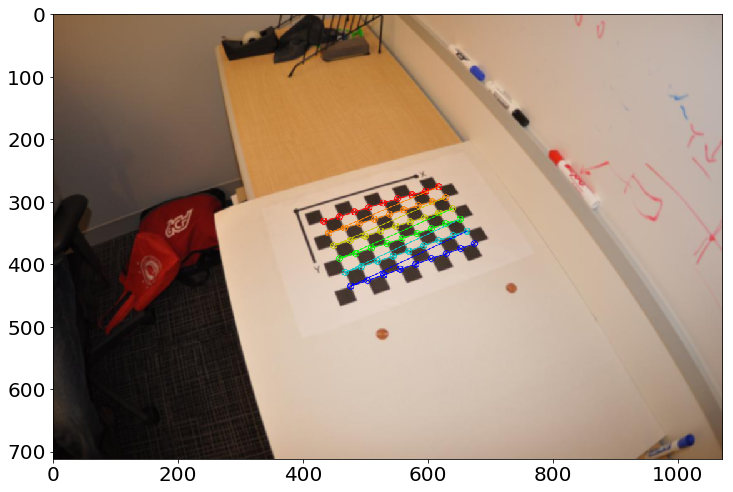

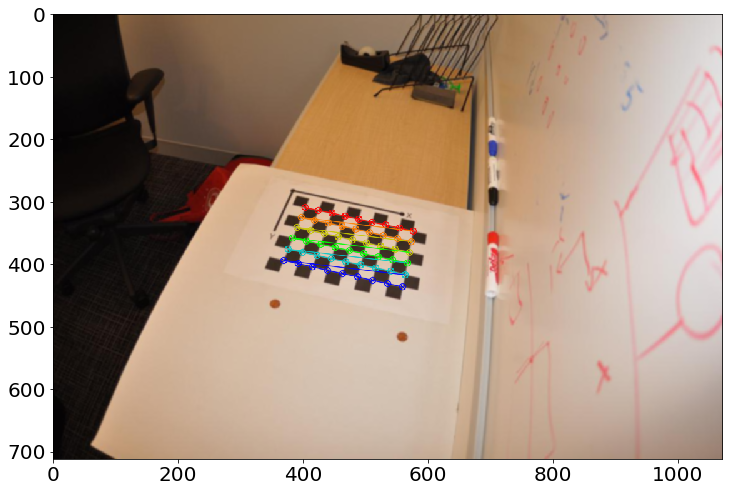

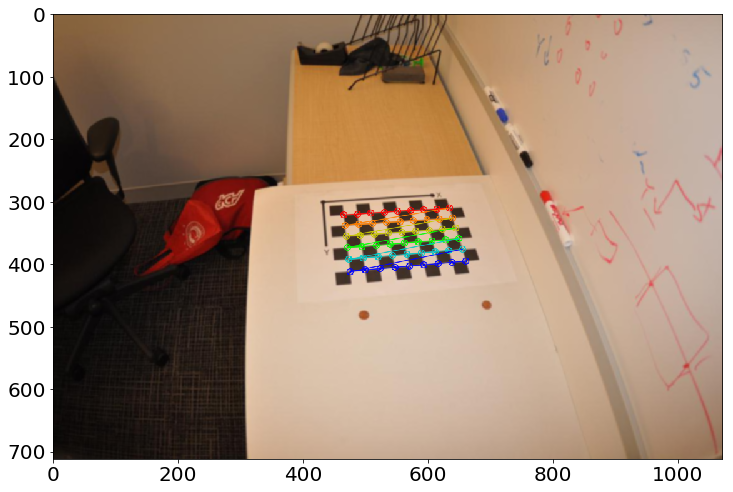

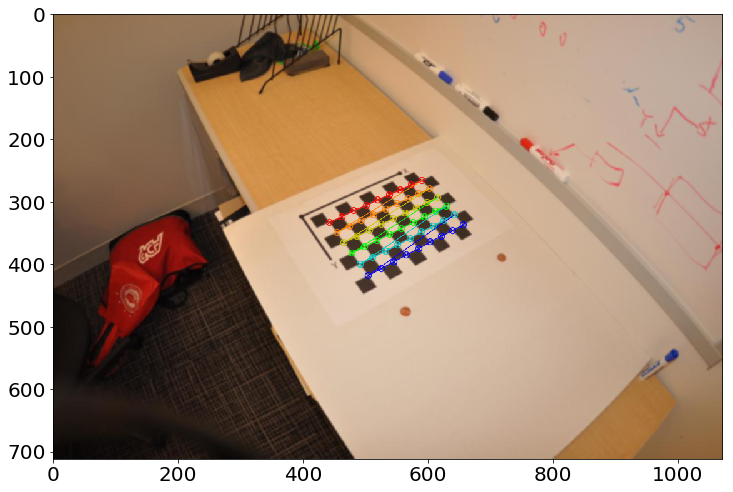

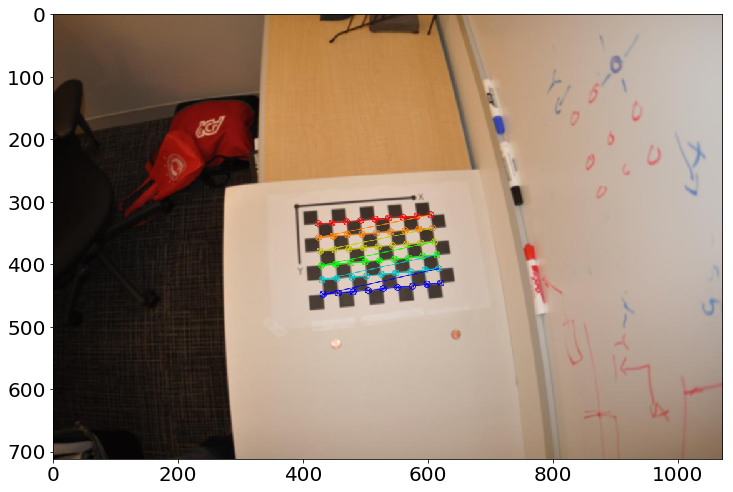

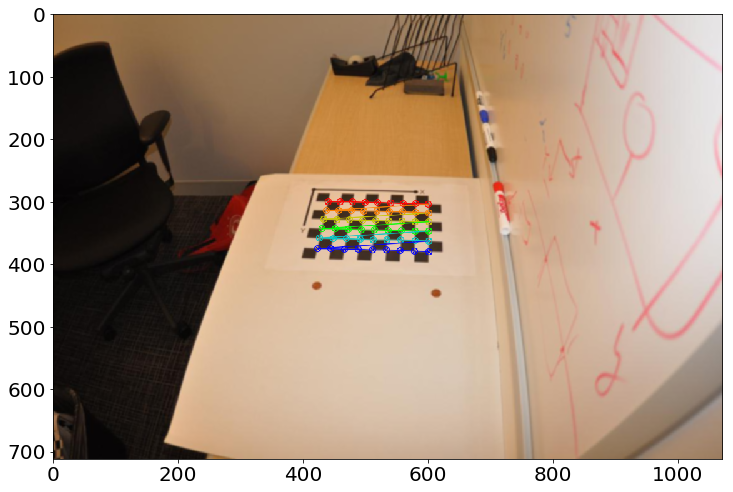

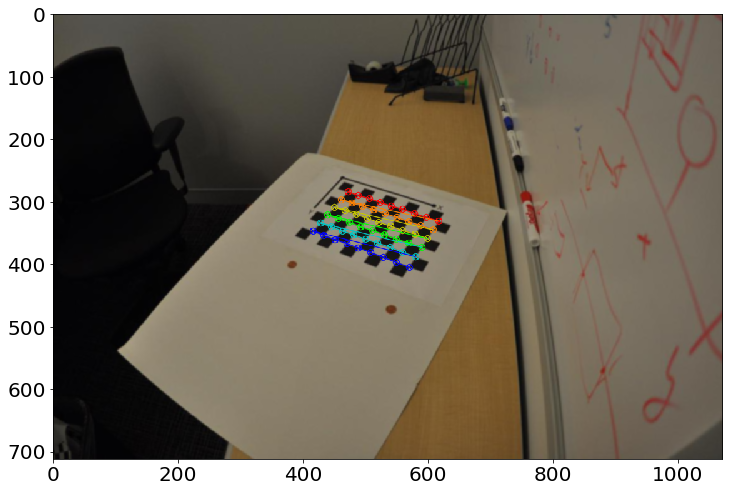

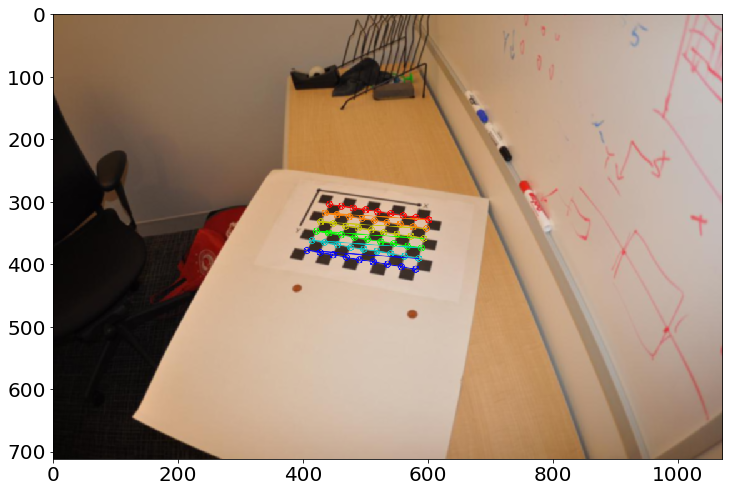

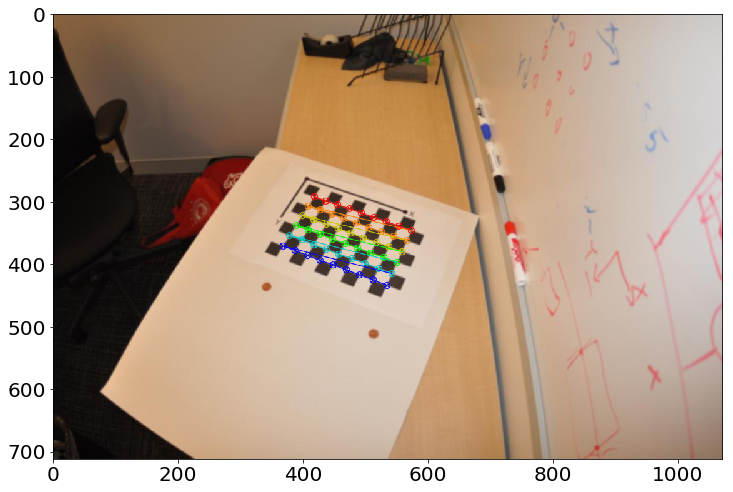

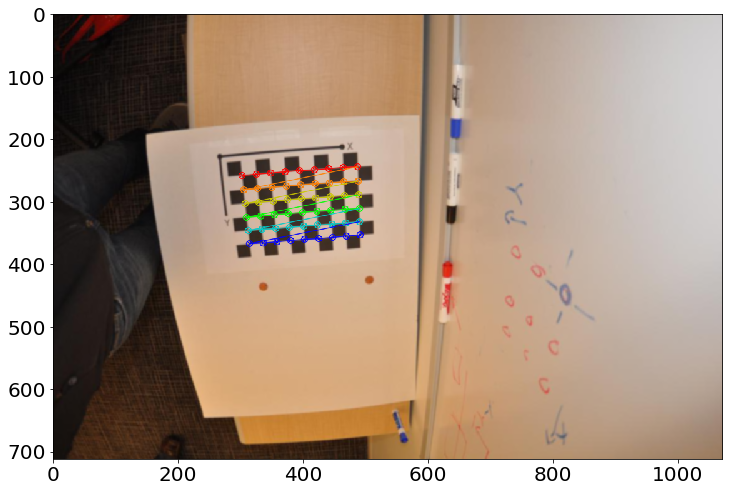

In [7]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob(images_path+'*.jpg')

for fname in images:
    
    img = cv2.imread(fname)
    img = cv2.GaussianBlur(img,(5,5),0)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    
    # Find the chess board corners    
    ret, corners = cv2.findChessboardCorners(gray, 
                                             pattern_size,
                                             None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        
        objpoints.append(objp)        
        
        corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)                
        imgpoints.append(corners)
                
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, pattern_size, corners,ret)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.show()        

## Camera Calibration
We use the function, cv2.calibrateCamera(). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   gray.shape[::-1],
                                                   None,
                                                   None)
print('camera matrix:\n')
print(mtx)
print('\n\ndistortion coefficients:\n')
print(dist)

camera matrix:

[[732.97246581   0.         577.19260368]
 [  0.         733.0907241  346.15800176]
 [  0.           0.           1.        ]]


distortion coefficients:

[[-0.42613611  0.47130607  0.00406209 -0.00605045 -0.30872275]]


## Re-projection Error

In [9]:
mean_error = 0
img_error = []
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    img_error.append(error)
    mean_error += error
mean_error/=len(objpoints)

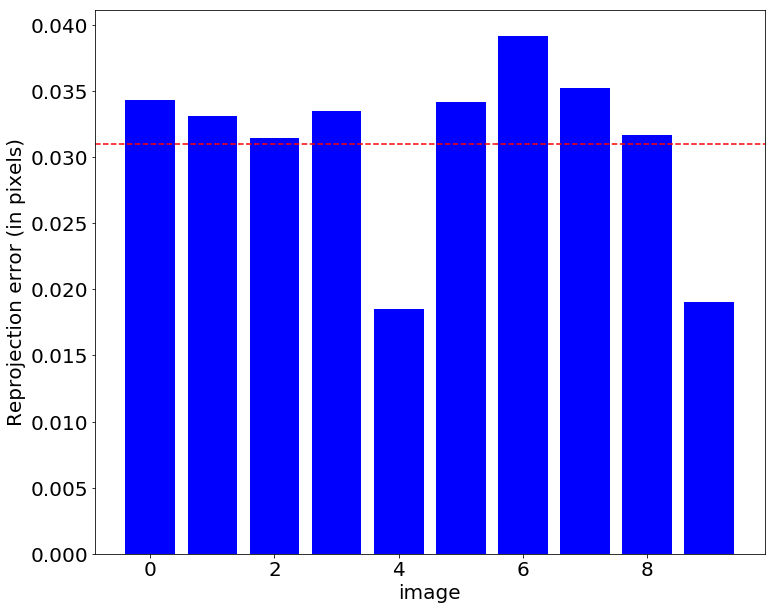

mean error: 0.031007179669042255


In [10]:
#plot reprojection error
plt.bar(list(range(i+1)), img_error, color="blue")
plt.axhline(y=mean_error, color='r', linestyle='--')
plt.xlabel('image',fontsize=20)
plt.ylabel('Reprojection error (in pixels)',fontsize=20)
plt.show()
print( "mean error: {}".format(mean_error) )

## Undistortion

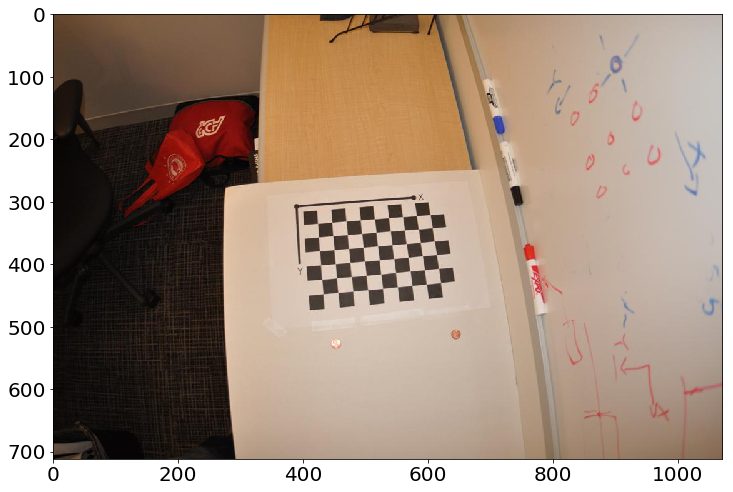

(712, 1072, 3)


In [11]:
img = cv2.imread(images_path+'image_dist_5.jpg')
h,  w = img.shape[:2]
#display image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show() 
print(img.shape)

In [12]:
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# print('camera matrix:\n')
# print(mtx)
# print('\n\n new camera matrix:\n')
# print(newcameramtx)
# print('\n\n roi:',roi)

In [13]:
roi

(613, 84, 233, 530)

* Using cv2.undistort()

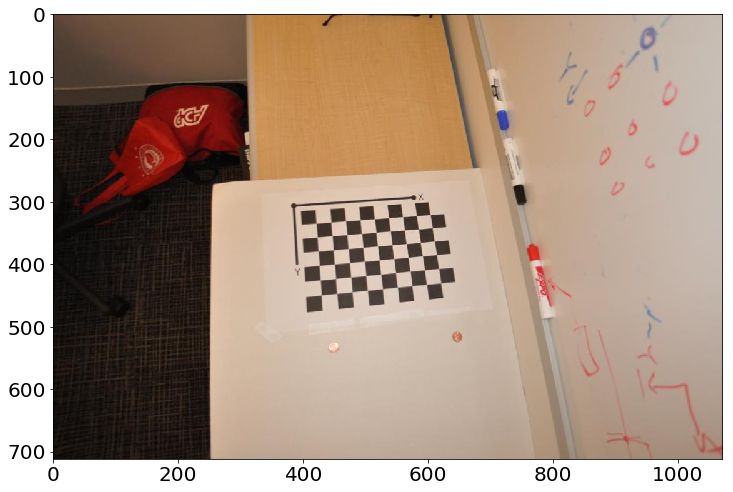

(712, 1072, 3)


In [14]:
# undistort
#dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
dst = cv2.undistort(img, mtx, dist,None)

# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()
print(dst.shape)

## Let's do an experiment!

### How camera parameters change by resizing images?
https://komputervision.wordpress.com/2016/03/21/intrinsic-camera-parameters-for-resized-images-set-of-a-chessboard/

https://dsp.stackexchange.com/questions/6055/how-does-resizing-an-image-affect-the-intrinsic-camera-matrix

What happens with the camera params if we resize the image?
We already computed the parametes for the images of size 1072x712.
So, let's keep these variables

In [15]:
#initialize dictionary to keep values already computed
dict_params = {}
dict_params['size'] = []
dict_params['mtx'] = []
dict_params['focal_length'] = []
dict_params['principal_point'] = []
dict_params['dist'] = []

In [16]:
#Saving results
dict_params['size'] += ['1072x712']
dict_params['mtx'] += [mtx]
dict_params['focal_length'] += [ [mtx[0,0], mtx[1,1]] ]
dict_params['principal_point'] += [ [mtx[0,2], mtx[1,2]] ]
dict_params['dist'] += [dist]

In [17]:
#Printing results
print('Image Size: {}'.format( dict_params['size'][0]) )
print('Focal Length: {}'.format(dict_params['focal_length'][0]))
print('Principal point: {}'.format(dict_params['principal_point'][0]))
print('Distortion: {}'.format(dict_params['dist'][0]))

Image Size: 1072x712
Focal Length: [732.9724658119613, 733.09072410144]
Principal point: [577.1926036794389, 346.1580017589948]
Distortion: [[-0.42613611  0.47130607  0.00406209 -0.00605045 -0.30872275]]


For convenience, let's transform the process  in a function

In [18]:
def calibration_from_img(images=None,
                           frame_step=20,
                           scale=0.4,
                           pattern_size=(9,6),
                           square_size=1.0,
                           criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.001),
                           debug=False):
    
    """[This function provides a calibration matrix extracted from a calibration video]
    Keyword Arguments:
        vid_file {[list[str]]} -- [List of string with the name of images] (default: {None})
        frame_step {int} -- [description] (default: {20})
        patern_size {tuple} -- [description] (default: {(9,6)})
        square_size {float} -- [description] (default: {1.0})
        criteria {tuple} -- [description] (default: {(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)})
        debug {boolean} -- [description] (default: {False})
    """       
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((np.prod(pattern_size), 3), np.float32)       
    objp[:,:2] = np.indices(pattern_size).T.reshape(-1, 2)
    objp *= square_size
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    num_pat_found = 0 # number of images where the pattern has been found
    num_images = 0 # number of images
    
    #reading the images
    for fname in images:
        
        img = cv2.imread(fname)
        
        #smoothing the image
        img = cv2.GaussianBlur(img,(5,5),0)
        
        #Resize    
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        
        #convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        (w,h) = gray.shape
        
        # Find the chess board corners    
        ret, corners = cv2.findChessboardCorners(gray, 
                                             pattern_size,
                                             None)
        
        # If found, add object points, image points (after refining them)
        if ret == True:        
            objpoints.append(objp)                
            corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)                
            imgpoints.append(corners)        
            
            if debug is True:
                print('Searching for chessboard in image: ' + str(fname) + '...')
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, pattern_size, corners, ret)
                plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
                #plt.axis('off')
                plt.show()
                print(gray.shape)
                    
    #Camera calibration
    print('computing cam params...')    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   (h,w),
                                                   None,
                                                   None)
    print('Done!')
    return ret, mtx, dist, rvecs, tvecs, w, h

Scale image and compute camera params

In [19]:
scale = .95
ret, mtx, dist, rvecs, tvecs, w, h = calibration_from_img(images, 
                                                    criteria=criteria,
                                                    scale=scale,
                                                   debug=False)

computing cam params...
Done!


In [20]:
#Saving results
dict_params['size'] += [str(h)+'x'+str(w)]
dict_params['mtx'] += [mtx]
dict_params['focal_length'] += [ [mtx[0,0], mtx[1,1]] ]
dict_params['principal_point'] += [ [mtx[0,2], mtx[1,2]] ]
dict_params['dist'] += [dist]

In [21]:
#Printing results
print('Image Scale: {}\n'.format(scale))
for i in range(len(dict_params['size'])):    
    print('Image Size: {}'.format( dict_params['size'][i]) )
    print('Focal Length: {}'.format(dict_params['focal_length'][i]))
    print('Principal Point: {}'.format(dict_params['principal_point'][i]))    
    print('Distortion: {}'.format(dict_params['dist'][i]))   
    print('\n')    


Image Scale: 0.95

Image Size: 1072x712
Focal Length: [732.9724658119613, 733.09072410144]
Principal Point: [577.1926036794389, 346.1580017589948]
Distortion: [[-0.42613611  0.47130607  0.00406209 -0.00605045 -0.30872275]]


Image Size: 1018x676
Focal Length: [701.2160938275285, 702.0868360271099]
Principal Point: [555.355120652465, 325.4956294167997]
Distortion: [[-0.41997173  0.32974462  0.00490043 -0.00675962  0.27818343]]




In [22]:
principal_point_ratio = []
focal_length_ratio = []
distortion_ratio = []

for i in range(len(dict_params['principal_point'])):
    
    focal_length_ratio+=\
    [dict_params['focal_length'][1][i]/dict_params['focal_length'][0][i]]
    
    principal_point_ratio +=\
    [dict_params['principal_point'][1][i]/dict_params['principal_point'][0][i]]
    
    
    
print('Focal Length Ratio: {}'.format(focal_length_ratio))
print('Principal Point Ratio: {}'.format(principal_point_ratio))  
print('\n')
print('Distortion Coeff img 1: {}'.format(dict_params['dist'][0]))
print('Distortion Coeff img 2: {}'.format(dict_params['dist'][1]))


Focal Length Ratio: [0.9566745362675333, 0.9577079793059284]
Principal Point Ratio: [0.9621660380126734, 0.940309418712843]


Distortion Coeff img 1: [[-0.42613611  0.47130607  0.00406209 -0.00605045 -0.30872275]]
Distortion Coeff img 2: [[-0.41997173  0.32974462  0.00490043 -0.00675962  0.27818343]]


### Let's test undistortions

First, let's try to undistort the resized image using the distortion coefficients computed from the original size images and the camera matrix computed from the resized images

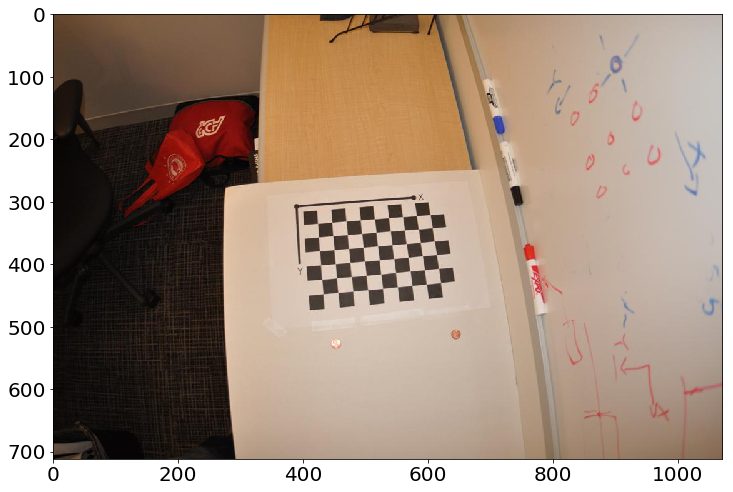

(712, 1072, 3)


In [23]:
img = cv2.imread(images_path+'image_dist_5.jpg')
h,  w = img.shape[:2]
#display image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show() 
print(img.shape)

Resize image

In [24]:
scale

0.95

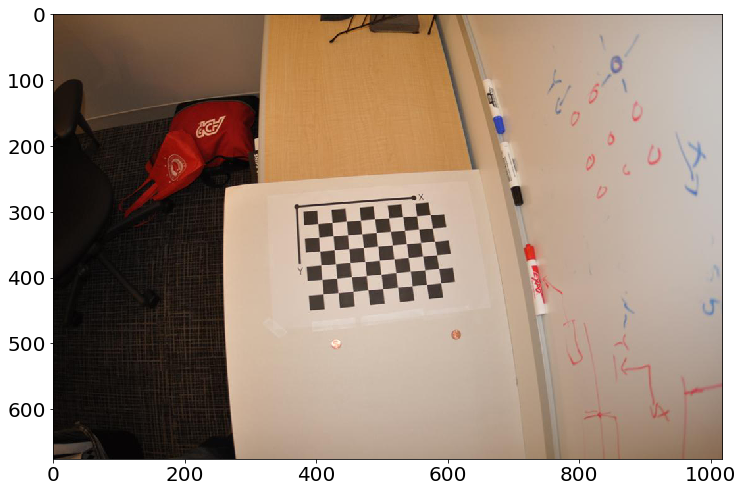

(676, 1018, 3)


In [25]:
img_resized = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
h,  w = img_resized.shape[:2]
#display image
plt.imshow(cv2.cvtColor(img_resized,cv2.COLOR_BGR2RGB))
plt.show() 
print(img_resized.shape)

In [26]:
new_mtx = (scale) * dict_params['mtx'][0]
new_mtx[-1] = 1
new_mtx

array([[696.32384252,   0.        , 548.3329735 ],
       [  0.        , 696.4361879 , 328.85010167],
       [  1.        ,   1.        ,   1.        ]])

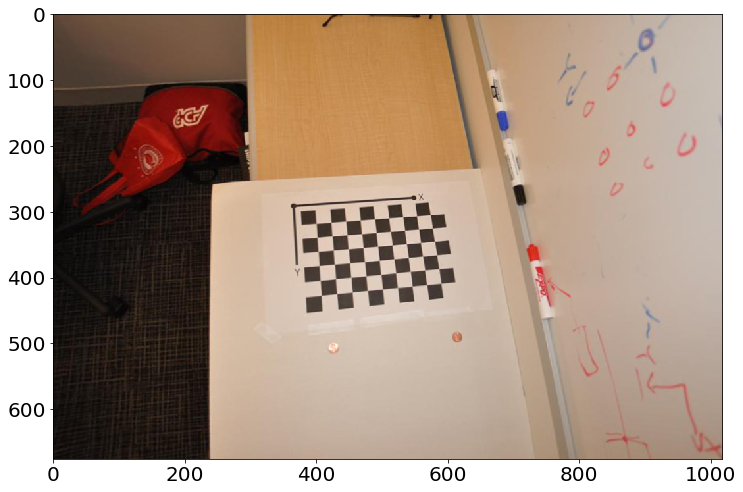

(676, 1018, 3)


In [27]:
# undistort
#dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
dst = cv2.undistort(img_resized, dict_params['mtx'][1], dict_params['dist'][0], None)

# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()
print(dst.shape)